[Open in Colab](https://colab.research.google.com/drive/1Wa9wKflkufymz7rByPj-JKlAsyFuYk_w?usp=sharing)

# 1. Imports Necessary Library

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shutil
import sys
import os.path

#necessary library
!pip install -q rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs


if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
        print("install cbc")
    else:
        try:
            !conda install -c conda-forge coincbc 
            print("install cbc-2")
        except:
            print("skip cbc")
            pass
            

assert(shutil.which("cbc") or os.path.isfile("cbc"))
    
from pyomo.environ import *

     |████████████████████████████████| 29.3 MB 1.4 MB/s 
     |████████████████████████████████| 11.1 MB 7.3 MB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting pre

# 2. Similarity Score Function

## 2.1. Similarity score of earth mover's distance for repeating units ensemble and end group ensemble 

In [ ]:
#from pyomo.common.fileutils import Executable
def Similarity_Score_EMD(query_smiles_list = None, 
                         query_smiles_level_list = None, 
                         target_smiles_list = None, 
                         target_smiles_level_list = None,
                         #level_weight = False,
                         #level_ratio = 3,
                         embedding_function = 'MorganFingerprint', #
                         similarity_score_function = 'Tanimoto', # Dice, Cosine
                         restrain_emd = False):
  
    #obtain the length of query smiles list and target smiles list
    if query_smiles_list != None:
        query_smiles_list_length = len(query_smiles_list)
    else:
        print ("Missing query smiles list")
        return    

    if target_smiles_list != None:
        target_smiles_list_length = len(target_smiles_list)
    else:
        print ("Missing target smiles list")
        return
    
    if set(query_smiles_list) == set(target_smiles_list):
        query_smiles_array = np.array(query_smiles_list)
        query_smiles_level_array = np.array(query_smiles_level_list)
        inds_query = query_smiles_array.argsort()
        sorted_query_smiles_array = query_smiles_array[inds_query]
        sorted_query_smiles_level_array = query_smiles_level_array[inds_query]

        target_smiles_array = np.array(target_smiles_list)
        target_smiles_level_array = np.array(target_smiles_level_list)
        inds_target = target_smiles_array.argsort()
        sorted_target_smiles_array = target_smiles_array[inds_target]
        sorted_target_smiles_level_array = target_smiles_level_array[inds_target]

        if np.array_equal(sorted_query_smiles_array, sorted_target_smiles_array) and np.array_equal(sorted_query_smiles_level_array, sorted_target_smiles_level_array):
            return 1

        query_smiles_reduced_list = list(set(query_smiles_list))
        query_smiles_reduced_list_number = []
        for i in range(0, len(query_smiles_reduced_list)):
            query_smiles_reduced_list_number_i  = 0
            for j in range(0, len(query_smiles_list)):
                if query_smiles_reduced_list[i] == query_smiles_list[j]:
                    query_smiles_reduced_list_number_i = query_smiles_reduced_list_number_i   + query_smiles_level_list[j]
            query_smiles_reduced_list_number.append(query_smiles_reduced_list_number_i/sum(query_smiles_level_list))

        target_smiles_reduced_list = list(set(target_smiles_list))
        target_smiles_reduced_list_number = []
        for i in range(0, len(target_smiles_reduced_list)):
            target_smiles_reduced_list_number_i  = 0
            for j in range(0, len(target_smiles_list)):
                if target_smiles_reduced_list[i] == target_smiles_list[j]:
                    target_smiles_reduced_list_number_i = target_smiles_reduced_list_number_i   + target_smiles_level_list[j]
            target_smiles_reduced_list_number.append(target_smiles_reduced_list_number_i/sum(target_smiles_level_list))

        if query_smiles_reduced_list_number == target_smiles_reduced_list_number:
            #print("check3")
            return 1.0

    if embedding_function == 'RDKFingerprint':    
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [Chem.RDKFingerprint(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [Chem.RDKFingerprint(x) for x in target_mol_list]

    elif embedding_function == 'MorganFingerprint':    
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=2048) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=2048) for x in target_mol_list]

    elif embedding_function == 'MACCSkeys':    
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in target_mol_list]


    else:
        print(embedding_function + " is not included in the current vision, please choose an available embedding function.");
        return False         

    Demand = {}
    Supply = {}
    T = {}

    if query_smiles_level_list == None or len(set(query_smiles_level_list)) ==1:
        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i+1)] = 1/query_smiles_list_length
    else:
        print("Query smiles list has different levels")
        #query_weight_sum = sum(query_smiles_level_list)
        #level 1, weight = 1; level 2, weight = 3^1;  level n, weight = 3^n-1
        query_weight_sum = 0.0
        for i in range(0, query_smiles_list_length):
            query_weight_sum = query_weight_sum + query_smiles_level_list[i]

        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i+1)] = query_smiles_level_list[i]/query_weight_sum
            #print("P" + str(i+1), Demand["P" + str(i+1)])


    if target_smiles_level_list == None or len(set(target_smiles_level_list)) ==1:       
        for j in range(0,target_smiles_list_length):
            Supply["Q" + str(j+1)] = 1/target_smiles_list_length
    else:
        print("Target smiles list has different levels")
        
        target_weight_sum = 0.0
        for j in range(0, target_smiles_list_length):
            target_weight_sum = target_weight_sum + target_smiles_level_list[j]

        for j in range(0, target_smiles_list_length):
            Supply["Q" + str(j+1)] = target_smiles_level_list[j]/target_weight_sum
            #print("Q" + str(j+1), Supply["Q" + str(j+1)])


    # embedding function and similarity 
    if similarity_score_function == 'Tanimoto':
        for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(query_fingerprint_list[i],target_fingerprint_list[j])
                print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )

    elif similarity_score_function == 'Dice':
        for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(query_fingerprint_list[i],target_fingerprint_list[j], metric=DataStructs.DiceSimilarity)
                #print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )

    elif similarity_score_function == 'Cosine':
        for i in range(0,query_smiles_list_length):
            for j in range(0,target_smiles_list_length):
                # calculate the fingerprint similarityscore between query[i],target[j] and input the distance = 1- similarityscore
                T[("P" + str(i+1), "Q" + str(j+1))] = 1 - DataStructs.FingerprintSimilarity(query_fingerprint_list[i],target_fingerprint_list[j], metric=DataStructs.CosineSimilarity)
                #print("P" + str(i+1), "->Q" + str(j+1), T[("P" + str(i+1), "Q" + str(j+1))] )
       
    else:
        print(similarity_score_function + " is not included in the current vision, please choose an available similarity function.");
        return

    

    #print(len(Demand), len(Supply), len(T))
    # Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # Step 2: Define the decision 
    model.x = Var(CUS, SRC, domain = NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c,s] for c in CUS]) == Supply[s])
        
    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])

    # add restrain to the EMD
    if restrain_emd == True: 
        model.restrain = ConstraintList()
        for i in range(0,query_smiles_list_length):
            model.restrain.add(model.x[CUS[i],SRC[i]] == Supply["Q" + str(i+1)])
    
    results = SolverFactory('cbc').solve(model)


    if 'ok' == str(results.Solver.status):
        #print("EMD(P,Q) = ",model.Cost())
        #print ("\n")
        #print("S(P,Q) = ", 1- model.Cost())
        SimilarityScore = 1- model.Cost()
        return SimilarityScore
        
    else:
        print("No Valid Solution Found")
        return False


    

## 2.2. Similarity score of Graph Edit Distance

In [ ]:
# Graph Edit Distance
def Similarity_Score_Graph_Edit_Distance(Graph1 = None, 
                         Graph2 = None, 
                         alpha = 1):
    if Graph1 == None:
        print("Missing Graph1")
        return
    if Graph2 == None:
        print("Missing Graph2")
        return
    
    # Since Graph1 is the subgraph of Graph2, the calculation of graph edit distance can be simpilified.
    Graph1_number = Graph1.number_of_nodes() + Graph1.number_of_edges()
    Graph2_number = Graph2.number_of_nodes() + Graph2.number_of_edges()

    #graph_edit_distance = abs(Graph2_number - Graph1_number)
    graph_edit_distance = nx.graph_edit_distance(Graph1, Graph2)

    # utilize the exponential decay function to turn the graph edit distance to similarity score
    #similarity_score = np.exp(-alpha*graph_edit_distance/(min(Graph1_number, Graph2_number))
    similarity_score = np.exp(-alpha*graph_edit_distance/(max(Graph1_number, Graph2_number)-graph_edit_distance))

    return similarity_score 

## 2.3. Mean value with different weights and different mean functions

In [ ]:
def Combined_Similarity_Score(Repeat_Unit_Similarity_Score = None,
                              Repeat_Unit_Weight = 0.5,
                              Graph_Similarity_Score = None,
                              Graph_Weight = 0.5,
                              End_Group_Similarity_Score = None,
                              End_Group_Weight = 0.0,
                              Mean_Function = 'arithmetic'):
  
    # Verify whether the weight sum is normalized.
    if  abs(Repeat_Unit_Weight + Graph_Weight +  End_Group_Weight -1 ) >=0.000000000001:
        print("Weight Sum is not normalized.")
        return False

    # Not consider the end group
    if End_Group_Similarity_Score == None:

        if Mean_Function == 'arithmetic':
            combined_similarity_score = (Repeat_Unit_Weight * Repeat_Unit_Similarity_Score + Graph_Weight * Graph_Similarity_Score)

        elif Mean_Function == 'geometric':
            combined_similarity_score = pow(Repeat_Unit_Similarity_Score,Repeat_Unit_Weight)*pow(Graph_Similarity_Score,Graph_Weight)

        else:
            print("Your input mean function ", Mean_Function, " is not implemented, please choose those implemented mean function, like arithmetic, geometric")
    
    # consider the end group
    else:
      
        if Mean_Function == 'arithmetic':
            combined_similarity_score = Repeat_Unit_Weight * Repeat_Unit_Similarity_Score + Graph_Weight * Graph_Similarity_Score + End_Group_Weight * End_Group_Similarity_Score

        elif Mean_Function == 'geometric':
            combined_similarity_score = pow(Repeat_Unit_Similarity_Score,Repeat_Unit_Weight)*pow(Graph_Similarity_Score,Graph_Weight)*pow(End_Group_Similarity_Score, End_Group_Weight)

        else:
            print("Your input mean function ", Mean_Function, " is not implemented, please choose those implemented mean function, like arithmetic, geometric")
            
    return combined_similarity_score


## 2.4. The Total Similarity Score between the query polymer and the target polymer

In [ ]:
def Similarity_Score_Two_Polymer(query = None,
                                 target = None,
                                 #level_weight = True,
                                 #level_ratio = 3,
                                 embedding_function = 'RDKFingerprint', #Embedding function
                                 similarity_score_function = 'Tanimoto', # Similarity function for two vectors
                                 restrain_emd = False, # Whether to restrain the emd
                                 alpha=1, #reduced parameter for the exponential decay function
                                 Repeat_Unit_Weight=0.5,
                                 Graph_Weight=0.5,
                                 End_Group_Weight = 0.0,
                                 Mean_Function = 'geometric',
                                 details_print = False):

    if query == None or target == None:
        print ("Either query polymer or target polymer is missing! Please check your input.")
        return False
    S_repeat_unit = Similarity_Score_EMD(query_smiles_list = query.repeat_unit_smiles_list, 
                     query_smiles_level_list = query.repeat_unit_smiles_level_list, 
                     target_smiles_list = target.repeat_unit_smiles_list, 
                     target_smiles_level_list = target.repeat_unit_smiles_level_list,
                     #level_weight = level_weight,
                     #level_ratio = level_ratio,	
                     embedding_function = embedding_function,
                     similarity_score_function = similarity_score_function,
                     restrain_emd = restrain_emd)
    
    S_graph = Similarity_Score_Graph_Edit_Distance(Graph1=query.graph_representation, 
                                                   Graph2=target.graph_representation, 
                                                   alpha=alpha)
    
    if End_Group_Weight == 0.0: 
        S_combined = Combined_Similarity_Score(Repeat_Unit_Similarity_Score=S_repeat_unit ,
                                       Repeat_Unit_Weight=Repeat_Unit_Weight,
                                       Graph_Similarity_Score=S_graph,
                                       Graph_Weight=Graph_Weight,
                                       End_Group_Similarity_Score = None,
                                       End_Group_Weight = End_Group_Weight,
                                       Mean_Function = Mean_Function)
        if details_print == True:
            print("Details of the Similarity Score:\n")
            print("Similarity score on Repeating Unit = ", S_repeat_unit, ", Weight for Repeating Unit = ", Repeat_Unit_Weight)
            print("Similarity score on Graph = ", S_graph, ", Weight for Graph = ", Graph_Weight)
            print("Similarity score on End Group = ", "None", ", Weight for End Group = ", End_Group_Weight)
            print("Similarity score Combined in " + Mean_Function + " mean = ", S_combined)
            print("\n")

        return S_combined 

    else: 
        S_end_group = Similarity_Score_EMD(query_smiles_list = query.end_group_smiles_list, 
                     query_smiles_level_list = query.end_group_smiles_level_list, 
                     target_smiles_list = target.end_group_smiles_list, 
                     target_smiles_level_list = target.end_group_smiles_level_list,
                     #level_weight = level_weight,
                     #level_ratio = level_ratio,	
                     embedding_function = embedding_function,
                     similarity_score_function = similarity_score_function,
                     restrain_emd = restrain_emd)
            
        S_combined = Combined_Similarity_Score(Repeat_Unit_Similarity_Score=S_repeat_unit ,
                                       Repeat_Unit_Weight=Repeat_Unit_Weight,
                                       Graph_Similarity_Score=S_graph,
                                       Graph_Weight=Graph_Weight,
                                       End_Group_Similarity_Score = S_end_group,
                                       End_Group_Weight = End_Group_Weight,
                                       Mean_Function = Mean_Function)
        
        if details_print == True:
            print("Details of the Similarity Score:\n")
            print("Similarity score on Repeating Unit = ", S_repeat_unit, ", Weight for Repeating Unit = ", Repeat_Unit_Weight)
            print("Similarity score on Graph = ", S_graph, ", Weight for Graph = ", Graph_Weight)
            print("Similarity score on End Group = ", S_end_group, ", Weight for End Group = ", End_Group_Weight )
            print("Similarity score Combined in " + Mean_Function + " mean = ", S_combined)
            print("\n")
            return S_combined, S_repeat_unit, S_graph, S_end_group

        return S_combined     


# 3. Define the Polymer Class

In [ ]:
class Polymer:
  def __init__(self, 
               repeat_unit_smiles_list=None, 
               repeat_unit_smiles_level_list=None, 
               end_group_smiles_list=None, 
               end_group_smiles_level_list=None,
               graph_representation=None):
    
      self.repeat_unit_smiles_list = repeat_unit_smiles_list
      self.repeat_unit_smiles_level_list = repeat_unit_smiles_level_list
      self.end_group_smiles_list = end_group_smiles_list
      self.end_group_smiles_level_list = end_group_smiles_level_list
      self.graph_representation = graph_representation

# 4. Some examples of Polymer Graph Representations

G0 number of nodes:  8
G0 number of edges:  11


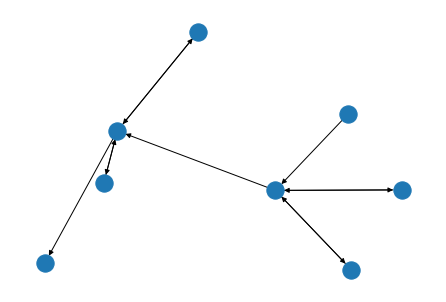

In [ ]:
G0 = nx.MultiDiGraph()
G0.add_node(1)
G0.add_node(2)
G0.add_node(3)
G0.add_node(4)
G0.add_node(5)
G0.add_node(6)
G0.add_node(7)
G0.add_node(8)
G0.add_edge(1, 2)
G0.add_edge(2, 3)
G0.add_edge(3, 4)
G0.add_edge(2, 5)
G0.add_edge(5, 2)
G0.add_edge(3, 6)
G0.add_edge(6, 3)
G0.add_edge(2,7)
G0.add_edge(7,2)
G0.add_edge(3,8)
G0.add_edge(8,3)
nx.draw(G0)
print("G0 number of nodes: ",G0.number_of_nodes())
print("G0 number of edges: ",G0.number_of_edges())

G0 number of nodes:  11
G0 number of edges:  16


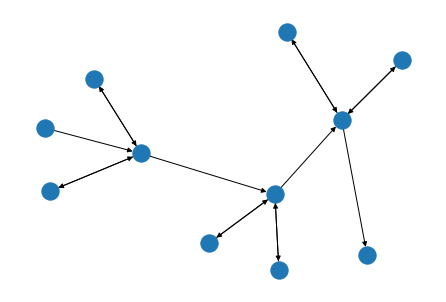

In [ ]:
G10 = nx.MultiDiGraph()
G10.add_node(1)
G10.add_node(2)
G10.add_node(3)
G10.add_node(4)
G10.add_node(5)
G10.add_node(6)
G10.add_node(7)
G10.add_node(8)

G10.add_node(9)
G10.add_node(10)
G10.add_node(11)

G10.add_edge(1, 2)
G10.add_edge(2, 3)
G10.add_edge(3, 4)
G10.add_edge(2, 5)
G10.add_edge(5, 2)
G10.add_edge(3, 6)
G10.add_edge(6, 3)
G10.add_edge(2,7)
G10.add_edge(7,2)
G10.add_edge(3,8)
G10.add_edge(8,3)
G10.add_edge(4,9)
G10.add_edge(4,10)
G10.add_edge(10,4)
G10.add_edge(4,11)
G10.add_edge(11,4)

nx.draw(G10)
print("G0 number of nodes: ",G10.number_of_nodes())
print("G0 number of edges: ",G10.number_of_edges())

G11 number of nodes:  14
G11 number of edges:  21


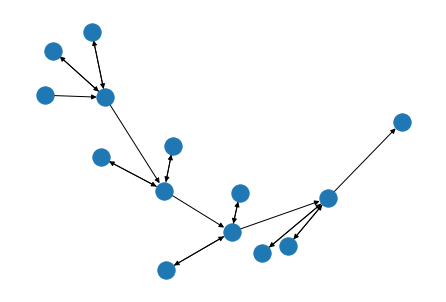

In [ ]:
G11 = nx.MultiDiGraph()
G11.add_node(1)
G11.add_node(2)
G11.add_node(3)
G11.add_node(4)
G11.add_node(5)
G11.add_node(6)
G11.add_node(7)
G11.add_node(8)

G11.add_node(9)
G11.add_node(10)
G11.add_node(11)

G11.add_node(12)
G11.add_node(13)
G11.add_node(14)

G11.add_edge(1, 2)
G11.add_edge(2, 3)
G11.add_edge(3, 4)
G11.add_edge(2, 5)
G11.add_edge(5, 2)
G11.add_edge(3, 6)
G11.add_edge(6, 3)
G11.add_edge(2,7)
G11.add_edge(7,2)
G11.add_edge(3,8)
G11.add_edge(8,3)

G11.add_edge(4,9)
G11.add_edge(4,10)
G11.add_edge(10,4)
G11.add_edge(4,11)
G11.add_edge(11,4)

G11.add_edge(9,12)
G11.add_edge(9,13)
G11.add_edge(13,9)
G11.add_edge(9,14)
G11.add_edge(14,9)



nx.draw(G11)
print("G11 number of nodes: ",G11.number_of_nodes())
print("G11 number of edges: ",G11.number_of_edges())

In [ ]:
PolymerE3_1 = Polymer(
   repeat_unit_smiles_list = ["*CC(*)(C)C","*CC(*)c1ccccc1"],
 repeat_unit_smiles_level_list = [1,1], 
 end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'], 
                      end_group_smiles_level_list = [1,1], 
 graph_representation = G0  
)


PolymerE3_2 =Polymer(
   repeat_unit_smiles_list = ["*CC(*)(C)C(=O)OC(C)C","*CC(*)c1ccccc1", '*CC(*)c1ccc(C)c(C)n1'],
 repeat_unit_smiles_level_list = [1,1,1], 
 end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'], 
                      end_group_smiles_level_list = [1,1], 
 graph_representation = G10  
)

PolymerE3_3 =Polymer(
 repeat_unit_smiles_list = ["*CC(*)(C)C","*CC(*)c1ccccc1", "*CC(*)(C)C(=O)OC","*CC(*)c1ccc(C)cc1"],
 #repeat_unit_smiles_list = ["*CC(*)(C)C","*CC(*)c1ccccc1", "*CC(*)(C)C","*CC(*)c1ccc(C)cc1"],
 repeat_unit_smiles_level_list = [1,1,1,1], 
 end_group_smiles_list = ['*C(C)(C)C#N','*C(C)(C)C#N'], 
 end_group_smiles_level_list = [1,1], 
 graph_representation = G11  
)


In [ ]:
STOT12, SRU12, STOP12, SEG12 = Similarity_Score_Two_Polymer(query = PolymerE3_1,
                             target = PolymerE3_2,
                             #level_weight = True,
                             #level_ratio = 3,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             restrain_emd = False,
                             alpha=1,
                             Repeat_Unit_Weight=0.575,
                             Graph_Weight=0.375,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=True)

P1 ->Q1 0.6799999999999999
P1 ->Q2 0.88
P1 ->Q3 0.8709677419354839
P2 ->Q1 0.8918918918918919
P2 ->Q2 0.0
P2 ->Q3 0.6129032258064516
Details of the Similarity Score:

Similarity score on Repeating Unit =  0.5260215026967742 , Weight for Repeating Unit =  0.575
Similarity score on Graph =  0.6563555554708402 , Weight for Graph =  0.375
Similarity score on End Group =  1 , Weight for End Group =  0.05
Similarity score Combined in geometric mean =  0.5902067854857256




In [ ]:
 STOT13, SRU13, STOP13, SEG13 = Similarity_Score_Two_Polymer(query = PolymerE3_1,
                             target = PolymerE3_3,
                             #level_weight = True,
                             #level_ratio = 3,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             restrain_emd = False,
                             alpha=1,
                             Repeat_Unit_Weight=0.575,
                             Graph_Weight=0.375,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=True)

P1 ->Q1 0.0
P1 ->Q2 0.88
P1 ->Q3 0.6363636363636364
P1 ->Q4 0.8461538461538461
P2 ->Q1 0.88
P2 ->Q2 0.0
P2 ->Q3 0.9142857142857143
P2 ->Q4 0.41666666666666663
Details of the Similarity Score:

Similarity score on Repeating Unit =  0.7367424242424243 , Weight for Repeating Unit =  0.575
Similarity score on Graph =  0.43080261519743523 , Weight for Graph =  0.375
Similarity score on End Group =  1 , Weight for End Group =  0.05
Similarity score Combined in geometric mean =  0.6117315636160962




In [ ]:
STOT23, SRU23, STOP23, SEG23 = Similarity_Score_Two_Polymer(query = PolymerE3_2,
                             target = PolymerE3_3,
                             #level_weight = True,
                             #level_ratio = 3,
                             embedding_function = 'MorganFingerprint',
                             similarity_score_function = 'Tanimoto',
                             restrain_emd = False,
                             alpha=1,
                             Repeat_Unit_Weight=0.575,
                             Graph_Weight=0.375,
                             End_Group_Weight = 0.05,
                             Mean_Function = 'geometric',
                             details_print=True)

P1 ->Q1 0.6799999999999999
P1 ->Q2 0.8918918918918919
P1 ->Q3 0.40740740740740744
P1 ->Q4 0.868421052631579
P2 ->Q1 0.88
P2 ->Q2 0.0
P2 ->Q3 0.9142857142857143
P2 ->Q4 0.41666666666666663
P3 ->Q1 0.8709677419354839
P3 ->Q2 0.6129032258064516
P3 ->Q3 0.9024390243902439
P3 ->Q4 0.5483870967741935
Details of the Similarity Score:

Similarity score on Repeating Unit =  0.5702001151086857 , Weight for Repeating Unit =  0.575
Similarity score on Graph =  0.7435670792059064 , Weight for Graph =  0.375
Similarity score on End Group =  1 , Weight for End Group =  0.05
Similarity score Combined in geometric mean =  0.6478295521906028




In [ ]:
E3_RU_matrix = np.array([[1.0, SRU12, SRU13],
                [SRU12, 1.0, SRU23],
                [SRU13, SRU23, 1.0]
                ])

E3_TOP_matrix = np.array([[1.0, STOP12, STOP13],
                [STOP12, 1.0, STOP23],
                [STOP13, STOP23, 1.0]
                ])


E3_TOT_matrix = np.array([[1.0, STOT12, STOT13],
                [STOT12, 1.0, STOT23],
                [STOT13, STOT23, 1.0]
                ])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

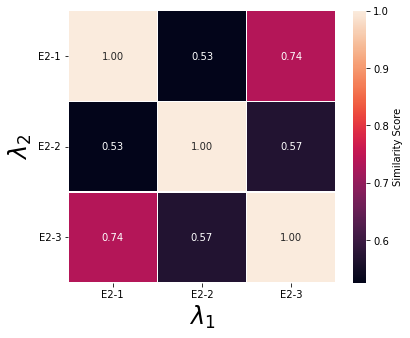

In [ ]:
fig,ax = plt.subplots(figsize=(6,5))

ax = sns.heatmap(E3_RU_matrix, linewidth=0.3, annot=True, fmt=".2f" , cbar_kws={'label': 'Similarity Score'})

x_labels = ["E2-1", "E2-2", "E2-3", "E2-4"]
y_labels = ["E2-1", "E2-2", "E2-3", "E2-4"]
#ax.set_xticks([x_to_num[v] for v in x_labels])
ax.set_xticklabels(x_labels, rotation=0, horizontalalignment='center')
#ax.set_yticks([y_to_num[v] for v in y_labels])
ax.set_yticklabels(y_labels, rotation=360, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)
resolution_value = 1200
#plt.savefig("myImage_heatmap.png", format="png", dpi=resolution_value , bbox_inches='tight')

plt.show()

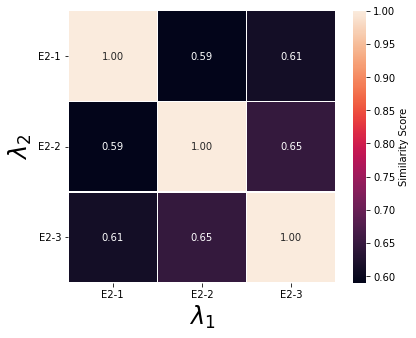

In [ ]:
fig,ax = plt.subplots(figsize=(6,5))

ax = sns.heatmap(E3_TOT_matrix, linewidth=0.3, annot=True, fmt=".2f" , cbar_kws={'label': 'Similarity Score'})

x_labels = ["E2-1", "E2-2", "E2-3", "E2-4"]
y_labels = ["E2-1", "E2-2", "E2-3", "E2-4"]
#ax.set_xticks([x_to_num[v] for v in x_labels])
ax.set_xticklabels(x_labels, rotation=0, horizontalalignment='center')
#ax.set_yticks([y_to_num[v] for v in y_labels])
ax.set_yticklabels(y_labels, rotation=360, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)
resolution_value = 1200
#plt.savefig("myImage_heatmap.png", format="png", dpi=resolution_value , bbox_inches='tight')

plt.show()

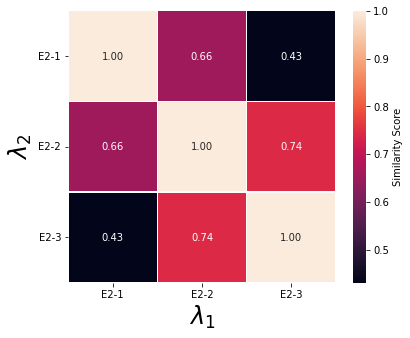

In [ ]:

fig,ax = plt.subplots(figsize=(6,5))

ax = sns.heatmap(E3_TOP_matrix, linewidth=0.3, annot=True, fmt=".2f" , cbar_kws={'label': 'Similarity Score'})

x_labels = ["E2-1", "E2-2", "E2-3", "E2-4"]
y_labels = ["E2-1", "E2-2", "E2-3", "E2-4"]
#ax.set_xticks([x_to_num[v] for v in x_labels])
ax.set_xticklabels(x_labels, rotation=0, horizontalalignment='center')
#ax.set_yticks([y_to_num[v] for v in y_labels])
ax.set_yticklabels(y_labels, rotation=360, horizontalalignment='right')
ax.set_xlabel(r"$\lambda_1$", size =24)
ax.set_ylabel(r"$\lambda_2$", size = 24)
resolution_value = 1200
#plt.savefig("myImage_heatmap.png", format="png", dpi=resolution_value , bbox_inches='tight')

plt.show()

In [ ]:
from scipy import io

In [ ]:
io.savemat("E3_TOT_matrix.mat", {"E3_TOT_matrix": E3_TOT_matrix})
io.savemat("E3_RU_matrix.mat", {"E3_RU_matrix": E3_RU_matrix})
io.savemat("E3_TOP_matrix.mat", {"E3_TOP_matrix": E3_TOP_matrix})